## Machine Learning Project


## Subject



## Problematic : Comment modéliser et prédire la maladie d’Alzheimer à partir de données cliniques, démographiques et liées au mode de vie, en utilisant des méthodes d’apprentissage automatique interprétables puis, déterminer les facteurs à risques.



## Members : Hoel ; Adja ; Nour

## Step1


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif
)
from sklearn.feature_selection import SequentialFeatureSelector



## (Lesson 1)

Chargement & nettoyage de base 

In [24]:
df = pd.read_csv("alzheimers_disease_data.csv")


# === OVERVIEW ===
print(df.shape)                     # rows × columns
print(df.info())                    # types + nulls
df.head()

# === Nettoyage par règles métier simples ===

# Exemple : bornes raisonnables pour l'âge
if "Age" in df.columns:
    df = df[(df["Age"] >= 0) & (df["Age"] <= 120)]

# Exemple : consommation d'alcool et activité physique ne peuvent pas être négatives
for col in ["AlcoholConsumption", "PhysicalActivity"]:
    if col in df.columns:
        df = df[df[col] >= 0]

print("Shape après règles simples :", df.shape)


# === STATISTICS ===
#print("Statistiques")
df.describe(include='all').T



(2149, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-n

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PatientID,2149.0,NaN,NaN,NaN,5825.0,620.507185,4751.0,5288.0,5825.0,6362.0,6899.0
Age,2149.0,NaN,NaN,NaN,74.908795,8.990221,60.0,67.0,75.0,83.0,90.0
Gender,2149.0,NaN,NaN,NaN,0.506282,0.500077,0.0,0.0,1.0,1.0,1.0
Ethnicity,2149.0,NaN,NaN,NaN,0.697534,0.996128,0.0,0.0,0.0,1.0,3.0
EducationLevel,2149.0,NaN,NaN,NaN,1.286645,0.904527,0.0,1.0,1.0,2.0,3.0
BMI,2149.0,NaN,NaN,NaN,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,NaN,NaN,NaN,0.288506,0.453173,0.0,0.0,0.0,1.0,1.0
AlcoholConsumption,2149.0,NaN,NaN,NaN,10.039442,5.75791,0.002003,5.13981,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,NaN,NaN,NaN,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,NaN,NaN,NaN,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346


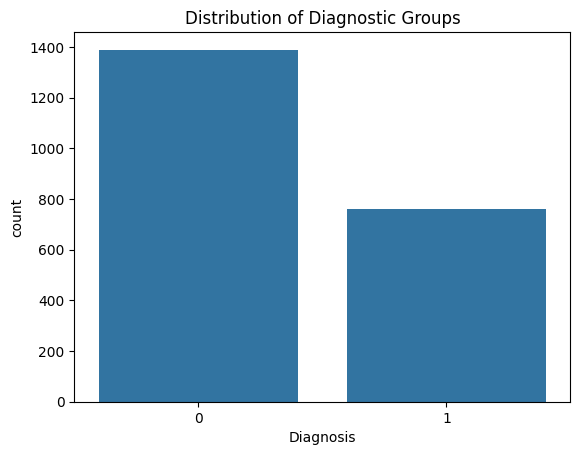

In [25]:
# Count target distribution
sns.countplot(x="Diagnosis", data=df)
plt.title("Distribution of Diagnostic Groups")
plt.show()

In [26]:
#On cherche les cases avec des valeurs manquantes par colonne
missing = df.isna().mean()*100
missing[missing>0].sort_values(ascending=False)

,0


In [27]:
#Capping (winsorisation) des valeurs extrêmes

num_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    q01 = df[col].quantile(0.01) #on enlève les valeurs en dessous de 1% des données
    q99 = df[col].quantile(0.99) #de même pour celles au-dessus du dernier 1%
    df[col] = df[col].clip(lower=q01, upper=q99) #on les remplace par q01 et q99

print("Capping terminé sur les colonnes numériques.")


#Suppression des outliers via IQR sur quelques colonnes clés

cols_outliers = [col for col in ["Age", "AlcoholConsumption", "PhysicalActivity"] if col in df.columns]

mask = pd.Series(True, index=df.index)

for col in cols_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask &= df[col].between(lower, upper)

df = df[mask]

print("Shape après suppression des outliers (IQR) :", df.shape)

Capping terminé sur les colonnes numériques.
Shape après suppression des outliers (IQR) : (2149, 35)


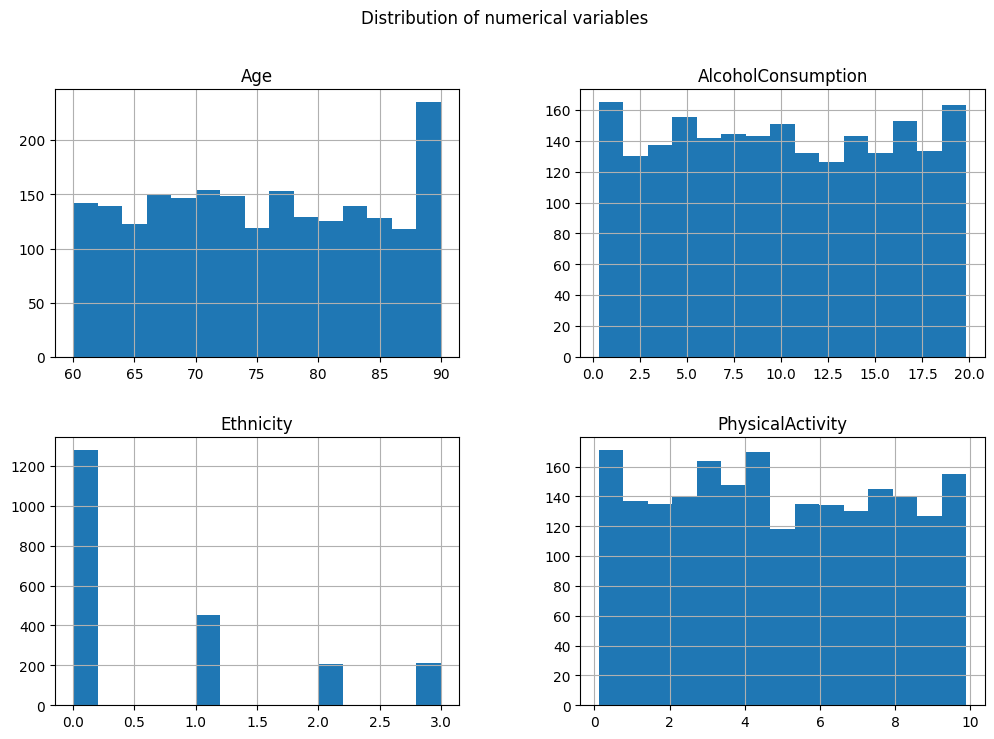

In [28]:
# Ratio par classe
df["Diagnosis"].value_counts(normalize=True) * 100

num_cols = ["Age", "AlcoholConsumption", "Ethnicity", "PhysicalActivity"]
df[num_cols].hist(figsize=(12, 8), bins=15)
plt.suptitle("Distribution of numerical variables")
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

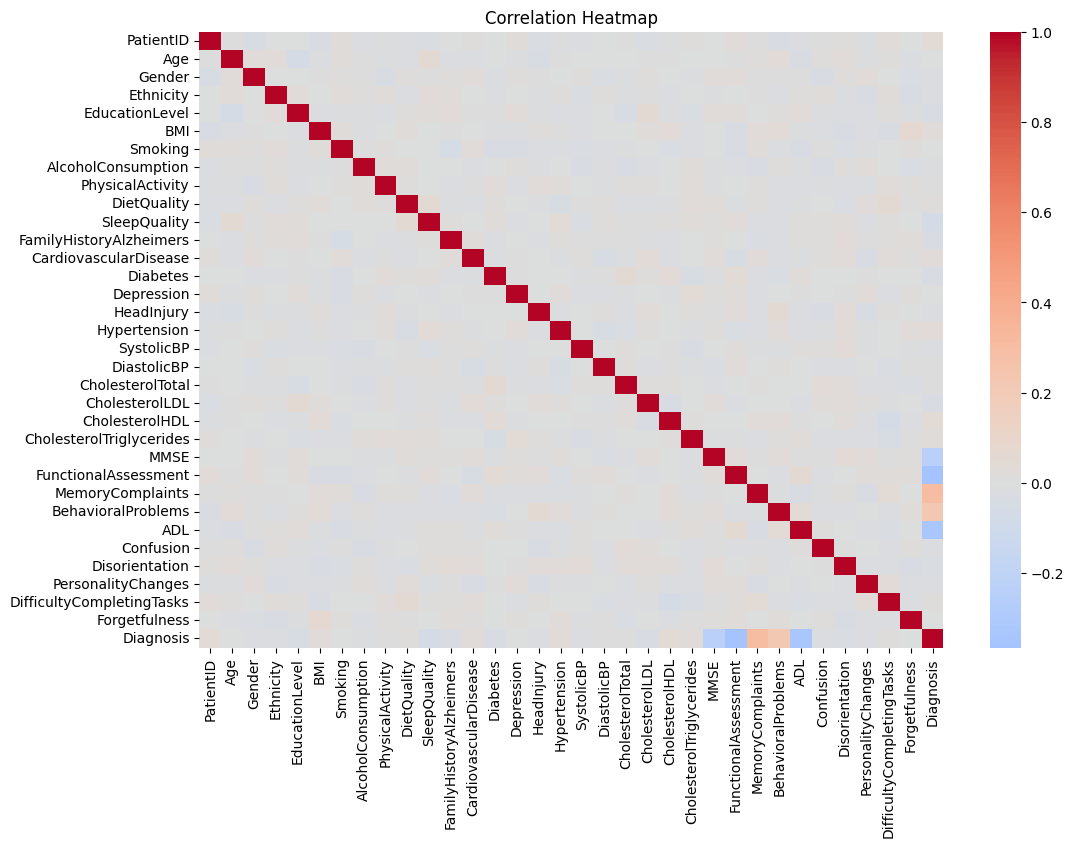

In [29]:
#CORRELATION (numeric only)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")

/tmp/ipython-input-3980030084.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Diagnosis", y="MMSE", palette="Set2")


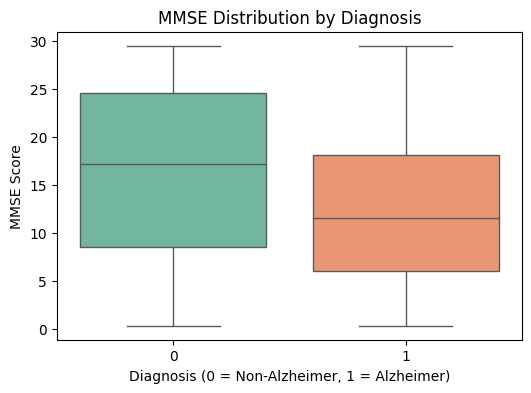

In [30]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Diagnosis", y="MMSE", palette="Set2")
plt.title("MMSE Distribution by Diagnosis")
plt.xlabel("Diagnosis (0 = Non-Alzheimer, 1 = Alzheimer)")
plt.ylabel("MMSE Score")
plt.show()


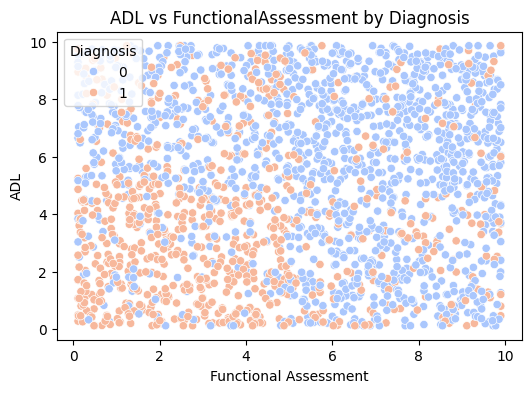

In [31]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="FunctionalAssessment", y="ADL", hue="Diagnosis", palette="coolwarm")
plt.title("ADL vs FunctionalAssessment by Diagnosis")
plt.xlabel("Functional Assessment")
plt.ylabel("ADL")
plt.show()


/tmp/ipython-input-1027041231.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_rate = df.groupby("AgeGroup")["Diagnosis"].mean().reset_index()
/tmp/ipython-input-1027041231.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_rate, x="AgeGroup", y="Diagnosis", palette="viridis")


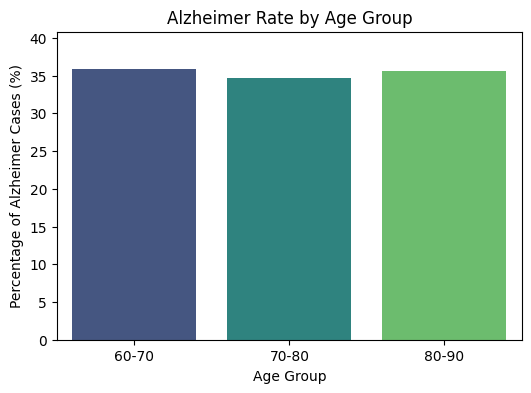

In [47]:
# Create age bins
df["AgeGroup"] = pd.cut(df["Age"], bins=[60, 70, 80, 90], labels=["60-70", "70-80", "80-90"])

# Compute Alzheimer rate per age group
age_rate = df.groupby("AgeGroup")["Diagnosis"].mean().reset_index()
age_rate["Diagnosis"] = age_rate["Diagnosis"] * 100  # convert to %

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=age_rate, x="AgeGroup", y="Diagnosis", palette="viridis")
plt.title("Alzheimer Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage of Alzheimer Cases (%)")
plt.ylim(0, age_rate["Diagnosis"].max() + 5)
plt.show()


/tmp/ipython-input-1917973276.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


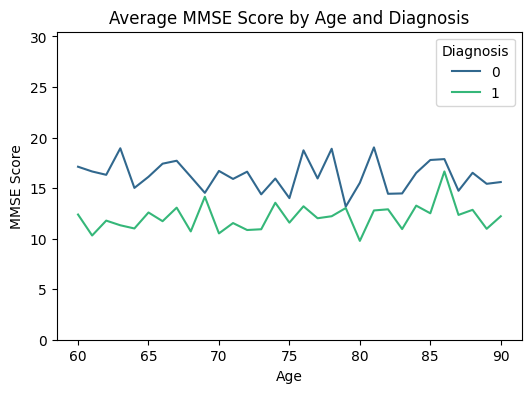

In [52]:
plt.figure(figsize=(6,4))
sns.lineplot(
    data=df, x="Age", y="MMSE",
    hue="Diagnosis", estimator="mean", ci=None,
    palette="viridis"
)
plt.title("Average MMSE Score by Age and Diagnosis")
plt.xlabel("Age")
plt.ylabel("MMSE Score")
plt.ylim(0, df["MMSE"].max()+1)
plt.show()


## Interpretation:

Le score MMSE diminue avec l’âge dans les deux groupes, mais les patients atteints de la maladie d’Alzheimer présentent des scores systématiquement plus faibles, ce qui confirme les schémas de déclin cognitif observés en pratique clinique.


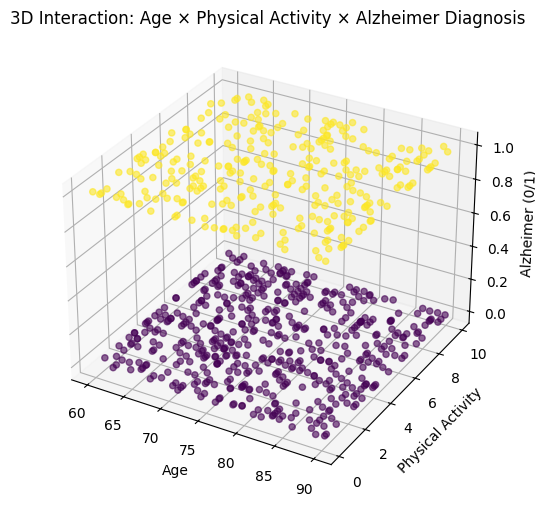

In [53]:
from mpl_toolkits.mplot3d import Axes3D

df_sample = df.sample(800)  # pour une visualisation plus légère

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_sample["Age"],
    df_sample["PhysicalActivity"],
    df_sample["Diagnosis"],
    c=df_sample["Diagnosis"],
    cmap="viridis", alpha=0.6
)

ax.set_xlabel("Age")
ax.set_ylabel("Physical Activity")
ax.set_zlabel("Alzheimer (0/1)")
plt.title("3D Interaction: Age × Physical Activity × Alzheimer Diagnosis")
plt.show()


## Cette visualisation confirme que l’âge est le principal facteur de risque de la maladie d’Alzheimer, mais elle montre également que des facteurs liés au mode de vie, comme l’activité physique, peuvent moduler ce risque, en particulier chez les populations âgées.


In [32]:
# Suppression des colonnes inutiles (identifiants, texte, etc.)
cols_to_drop = ["PatientID", "DoctorInCharge","BMI"]  # infos non pertinentes
df = df.drop(columns=cols_to_drop, errors="ignore")

print("\n Colonnes supprimées :", cols_to_drop)

# Séparation des types de colonnes
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# === Discrétisation de l'âge en tranches (hiérarchie Age -> AgeGroup) ===
if "Age" in df.columns:
    bins = [0, 45, 65, 120]  # bornes à adapter si besoin
    labels = ["Jeune", "Adulte", "Senior"]
    df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False)

    print(df[["Age", "AgeGroup"]].head())


print("\nColonnes numériques :", num_cols)
print("Colonnes catégorielles :", cat_cols if len(cat_cols) > 0 else "Aucune")

# Gestion des valeurs manquantes
# Numériques → remplacement par la médiane
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Catégorielles → remplacement par la valeur la plus fréquente (mode)
if len(cat_cols) > 0:
    df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])
    print("\n Valeurs manquantes catégorielles remplacées.")
else:
    print("\n Aucune colonne catégorielle à traiter.")

# === Discrétisation d'un score continu en niveaux ===
if "AlcoholConsumption" in df.columns:
    df["AlcoholLevel"] = pd.qcut(
        df["AlcoholConsumption"],
        q=3,
        labels=["Faible", "Moyen", "Élevé"]
    )

    print(df[["AlcoholConsumption", "AlcoholLevel"]].head())

# Recalcul des colonnes numériques / catégorielles après ajout des nouvelles variables
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

print("Colonnes numériques :", num_cols)
print("Colonnes catégorielles :", cat_cols)

# Encodage des variables catégorielles (texte → numérique)
if len(cat_cols) > 0:
    le = LabelEncoder()
    for c in cat_cols:
        df[c] = le.fit_transform(df[c])
    print(" Encodage des variables catégorielles terminé.")
else:
    print(" Rien à encoder (aucune variable catégorielle).")

# Vérification de la variable cible
if "Diagnosis" not in df.columns:
    raise ValueError(" La colonne 'Diagnosis' est manquante dans le dataset !")

print("\nRépartition de la variable cible (Diagnosis) :")
print(df["Diagnosis"].value_counts())

# Séparation des features (X) et de la cible (y)
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

# Division du dataset en jeu d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTaille du jeu d'entraînement :", x_train.shape)
print("Taille du jeu de test :", x_test.shape)

# Normalisation / Standardisation
scaler_STD = StandardScaler()
scaler_NORM = MinMaxScaler()

# Standardisation (centrée-réduite)
x_train_STD = scaler_STD.fit_transform(x_train)
x_test_STD = scaler_STD.transform(x_test)

# Normalisation (entre 0 et 1)
x_train_NORM = scaler_NORM.fit_transform(x_train)
x_test_NORM = scaler_NORM.transform(x_test)

# Vérifications finales
print("\n=== données standardisées ===")
display(pd.DataFrame(x_train_STD, columns=X.columns).head())

print("\n=== données normalisées ===")
display(pd.DataFrame(x_train_NORM, columns=X.columns).head())

print("\n Pré-traitement terminé avec succès !")


 Colonnes supprimées : ['PatientID', 'DoctorInCharge', 'BMI']
   Age AgeGroup
0   73   Senior
1   89   Senior
2   73   Senior
3   74   Senior
4   89   Senior

Colonnes numériques : ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis']
Colonnes catégorielles : Aucune

 Aucune colonne catégorielle à traiter.
   AlcoholConsumption AlcoholLevel
0           13.297218        Moyen
1            4.542524       Faible
2           19.555085        Élevé
3           12.209266        Moyen
4           18.454356  

,Age,Gender,Ethnicity,EducationLevel,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,AgeGroup,AlcoholLevel
0,1.230721,-1.009939,1.298741,-0.317924,-0.642254,1.479254,0.571510,-1.277199,1.458247,1.726026,...,-0.508349,-0.413498,-1.604533,-0.508349,-0.425962,-0.421186,-0.433561,1.506008,0.438286,1.202585
1,-1.430841,0.990159,-0.703533,1.903666,1.557017,-0.407839,-1.050829,0.340493,-1.136263,-0.579365,...,-0.508349,-0.413498,-1.533740,-0.508349,-0.425962,-0.421186,-0.433561,-0.664007,-2.281617,-0.017028
2,0.010838,-1.009939,-0.703533,-1.428719,-0.642254,-0.288650,1.629333,-1.119811,0.513127,-0.579365,...,-0.508349,-0.413498,-0.020492,-0.508349,-0.425962,-0.421186,-0.433561,-0.664007,0.438286,-0.017028
3,1.563416,-1.009939,-0.703533,-1.428719,-0.642254,-1.419329,-1.258277,1.280467,1.255740,-0.579365,...,1.967152,-0.413498,0.060328,-0.508349,2.347629,-0.421186,-0.433561,1.506008,0.438286,-1.236641
4,0.121737,0.990159,-0.703533,0.792871,1.557017,-0.190650,1.189684,0.982817,-0.632375,-0.579365,...,-0.508349,-0.413498,1.499525,-0.508349,-0.425962,-0.421186,-0.433561,1.506008,0.438286,-0.017028



=== données normalisées ===


,Age,Gender,Ethnicity,EducationLevel,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,AgeGroup,AlcoholLevel
0,0.866667,0.0,0.666667,0.333333,0.0,0.937680,0.656335,0.125331,0.944729,1.0,...,0.0,0.0,0.012183,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.066667,1.0,0.000000,1.000000,1.0,0.381486,0.183403,0.605117,0.167841,0.0,...,0.0,0.0,0.033660,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.500000,0.0,0.000000,0.000000,0.0,0.416615,0.964703,0.172011,0.661726,0.0,...,0.0,0.0,0.492745,0.0,0.0,0.0,0.0,0.0,1.0,0.5
3,0.966667,0.0,0.000000,0.000000,0.0,0.083363,0.122930,0.883901,0.884091,0.0,...,1.0,0.0,0.517263,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.533333,1.0,0.000000,0.666667,1.0,0.445499,0.836540,0.795621,0.318723,0.0,...,0.0,0.0,0.953883,0.0,0.0,0.0,0.0,1.0,1.0,0.5



 Pré-traitement terminé avec succès !


In [33]:
# PCA qui garde 95 % de la variance
pca = PCA(n_components=0.95, random_state=42)

x_train_PCA = pca.fit_transform(x_train_STD)
x_test_PCA = pca.transform(x_test_STD)

print("Nombre de composantes PCA retenues :", pca.n_components_)
print("Variance expliquée cumulée :", pca.explained_variance_ratio_.sum())

log_reg_pca = LogisticRegression(max_iter=1000, random_state=42)
log_reg_pca.fit(x_train_PCA, y_train)

y_pred_pca = log_reg_pca.predict(x_test_PCA)

print("=== Résultats Logistic Regression avec PCA ===")
print(classification_report(y_test, y_pred_pca))


Nombre de composantes PCA retenues : 30
Variance expliquée cumulée : 0.9631927875511751
=== Résultats Logistic Regression avec PCA ===
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       278
           1       0.75      0.76      0.75       152

    accuracy                           0.82       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.82      0.82      0.82       430



In [34]:
# On garde les 10 meilleures variables (à adapter)
selector = SelectKBest(score_func=f_classif, k=10)

x_train_KBest = selector.fit_transform(x_train_STD, y_train)
x_test_KBest = selector.transform(x_test_STD)

# Noms des variables sélectionnées
selected_features = X.columns[selector.get_support()]
print("Variables sélectionnées par SelectKBest :")
print(selected_features)

rf_kbest = RandomForestClassifier(random_state=42)
rf_kbest.fit(x_train_KBest, y_train)
y_pred_kbest = rf_kbest.predict(x_test_KBest)

print("=== Résultats Random Forest avec SelectKBest ===")
print(classification_report(y_test, y_pred_kbest))


# Sauvegarde compressée des features PCA et des labels
np.savez_compressed(
    "alzheimers_features_PCA.npz",
    x_train=x_train_PCA,
    x_test=x_test_PCA,
    y_train=y_train,
    y_test=y_test
)

print("Fichier compressé alzheimers_features_PCA.npz créé.")


Variables sélectionnées par SelectKBest :
Index(['SleepQuality', 'CardiovascularDisease', 'SystolicBP', 'CholesterolHDL',
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL'],
      dtype='object')
=== Résultats Random Forest avec SelectKBest ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       278
           1       0.94      0.92      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430

Fichier compressé alzheimers_features_PCA.npz créé.


Accuracy : 0.813953488372093
F1-score : 0.8136708570078502
ROC-AUC : 0.8853180613404015


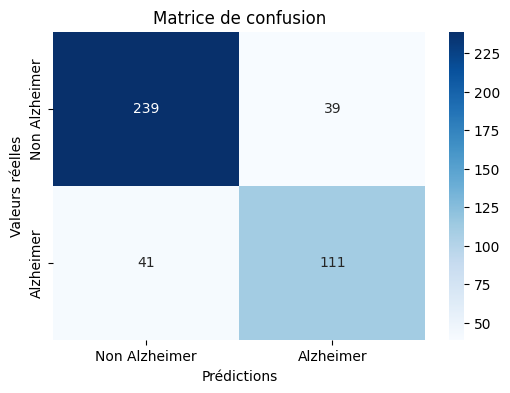

In [35]:
# FORMALISATION DU PROBLÈME

# ---------------------------------------------------------------
# Séparation des données (x_train_STD, x_test_STD sont déjà définis)
# ---------------------------------------------------------------
# x_train_STD, x_test_STD sont déjà préparés dans ton code précédent

# Création du modèle (régression logistique)
model = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement du modèle sur le jeu d'entraînement
model.fit(x_train_STD, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(x_test_STD)
y_prob = model.predict_proba(x_test_STD)[:, 1]

# ---------------------------------------------------------------
# Calcul des métriques
# ---------------------------------------------------------------
# Accuracy
acc = accuracy_score(y_test, y_pred)

# F1-score (prend en compte la précision et le rappel)
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC-AUC (aire sous la courbe ROC)
roc_auc = roc_auc_score(y_test, y_prob)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage des résultats
print("Accuracy :", acc)
print("F1-score :", f1)
print("ROC-AUC :", roc_auc)

# Affichage de la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=["Non Alzheimer", "Alzheimer"], yticklabels=["Non Alzheimer", "Alzheimer"])
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion")
plt.show()

log_base = model


Accuracy (Random Forest) : 0.9348837209302325
F1-score (Random Forest) : 0.9342335632142649
ROC-AUC (Random Forest) : 0.9446942446043165


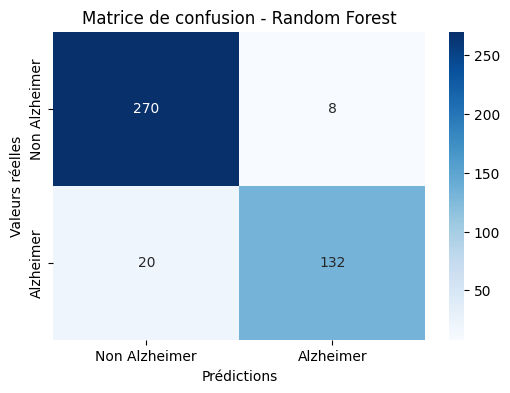

In [36]:
#On teste un autre model pour reduire les FP et les FN

# Séparation des données (x_train_STD, x_test_STD sont déjà définis)
# x_train_STD, x_test_STD sont déjà préparés dans ton code précédent

# Création du modèle (Random Forest)
model_rf = RandomForestClassifier(random_state=42)

# Entraînement du modèle sur le jeu d'entraînement
model_rf.fit(x_train_STD, y_train)

# Prédictions sur le jeu de test
y_pred_rf = model_rf.predict(x_test_STD)
y_prob_rf = model_rf.predict_proba(x_test_STD)[:, 1]

# Calcul des métriques

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)

# F1-score (prend en compte la précision et le rappel)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# ROC-AUC (aire sous la courbe ROC)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Affichage des résultats
print("Accuracy (Random Forest) :", acc_rf)
print("F1-score (Random Forest) :", f1_rf)
print("ROC-AUC (Random Forest) :", roc_auc_rf)

# Affichage de la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap='Blues', xticklabels=["Non Alzheimer", "Alzheimer"], yticklabels=["Non Alzheimer", "Alzheimer"])
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion - Random Forest")
plt.show()


In [37]:
# y =  variable cible (df["Diagnosis"] après encodage)
print("Nombre d’exemples par classe (global) :")
print(Counter(y))

# Sur le train uniquement (important pour la réalité du modèle)
print("Nombre d’exemples par classe (train) :")
print(Counter(y_train))

# Calcul du ratio majoritaire/minoritaire
counts = Counter(y_train)
majority = max(counts.values())
minority = min(counts.values())
ratio = majority / minority
print(f"Ratio majoritaire/minoritaire : {ratio:.2f} : 1")


Nombre d’exemples par classe (global) :
Counter({0: 1389, 1: 760})
Nombre d’exemples par classe (train) :
Counter({0: 1111, 1: 608})
Ratio majoritaire/minoritaire : 1.83 : 1


## Pour 1 patient Alzheimer (classe 1), tu as environ 1,8 patients non Alzheimer (classe 0).
## La distribution des classes est légèrement déséquilibrée : environ 65 % de classe 0 et 35 % de classe 1, soit un ratio d’environ 1.8:1. Il ne s’agit pas d’un déséquilibre extrême, mais cela justifie l’utilisation de métriques comme le recall et le F1-score pour la classe Alzheimer, et l’essai de techniques de gestion du déséquilibre (class_weight, SMOTE, etc.)
## Les chiffres global vs train sont très proches. Ca montre que le train_test_split a bien conservé la proportion des classes

In [38]:
# === Decision Tree SANS gestion du déséquilibre ===
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(x_train, y_train)
y_pred_dt = dt_baseline.predict(x_test)

print("=== Decision Tree SANS gestion du déséquilibre ===")
print(classification_report(y_test, y_pred_dt))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_dt))

# === Decision Tree AVEC class_weight='balanced' ===
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_balanced.fit(x_train, y_train)
y_pred_dt_bal = dt_balanced.predict(x_test)

print("\n=== Decision Tree AVEC class_weight='balanced' ===")
print(classification_report(y_test, y_pred_dt_bal))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_dt_bal))


=== Decision Tree SANS gestion du déséquilibre ===
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       278
           1       0.83      0.90      0.86       152

    accuracy                           0.90       430
   macro avg       0.89      0.90      0.89       430
weighted avg       0.90      0.90      0.90       430

Matrice de confusion :
[[250  28]
 [ 15 137]]

=== Decision Tree AVEC class_weight='balanced' ===
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       278
           1       0.86      0.86      0.86       152

    accuracy                           0.90       430
   macro avg       0.89      0.89      0.89       430
weighted avg       0.90      0.90      0.90       430

Matrice de confusion :
[[257  21]
 [ 21 131]]


## Oversampling maison de la classe minoritaire ===

In [40]:


# On repart de x_train (DataFrame) et y_train (Series)
X_train_df = x_train.copy()
y_train_df = y_train.copy()

print("Avant oversampling :", Counter(y_train_df))

# Identifier classe majoritaire / minoritaire
classe_majoritaire = y_train_df.value_counts().idxmax()
classe_minoritaire = y_train_df.value_counts().idxmin()

X_major = X_train_df[y_train_df == classe_majoritaire]
y_major = y_train_df[y_train_df == classe_majoritaire]

X_minor = X_train_df[y_train_df == classe_minoritaire]
y_minor = y_train_df[y_train_df == classe_minoritaire]

# Oversampling de la classe minoritaire pour avoir autant d'exemples que la classe majoritaire
X_minor_upsampled, y_minor_upsampled = resample(
    X_minor,
    y_minor,
    replace=True,                     # tirage avec remise
    n_samples=len(y_major),           # même nombre que la classe majoritaire
    random_state=42
)

# Réunir les deux
X_train_os = pd.concat([X_major, X_minor_upsampled])
y_train_os = pd.concat([y_major, y_minor_upsampled])

print("Après oversampling :", Counter(y_train_os))

# Decision Tree sur les données oversamplées
dt_os = DecisionTreeClassifier(random_state=42)
dt_os.fit(X_train_os, y_train_os)
y_pred_dt_os = dt_os.predict(x_test)

print("\n=== Decision Tree après oversampling aléatoire ===")
print(classification_report(y_test, y_pred_dt_os))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_dt_os))


Avant oversampling : Counter({0: 1111, 1: 608})


NameError: name 'resample' is not defined

## Comme le déqéquilibre est léger on n'utilise pas de SMOTE, on peut rester sur class_weight ou l'oversampling ci-dessous

## La variable cible présente un léger déséquilibre (environ 65 % de classe 0 et 35 % de classe 1, soit un ratio ≈ 1.8:1). Pour limiter l’impact de ce déséquilibre, nous avons testé deux approches :

## - un ajustement des poids de classes au niveau de l’algorithme (class_weight='balanced' dans un arbre de décision) ;

## - un oversampling de la classe minoritaire au niveau des données, en dupliquant aléatoirement des exemples de la classe Alzheimer jusqu’à obtenir un jeu d’entraînement équilibré.

## L’oversampling “maison” permet d’illustrer le principe des techniques de rééchantillonnage (comme SMOTE) sans dépendre de bibliothèques externes (je n'arrivais pas à la télécharger). Nous comparons ensuite les performances (recall et F1-score de la classe Alzheimer) entre le modèle de base, le modèle pondéré et le modèle entraîné après oversampling.

In [41]:
# Probas pour la classe positive (Alzheimer = 1)
y_score = dt_balanced.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Hasard')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve – Decision Tree balanced')
plt.legend()
plt.show()


NameError: name 'auc' is not defined

## Lesson 5

In [ ]:

# Arbre Gini (défaut de scikit-learn)
dt_gini = DecisionTreeClassifier(criterion="gini", random_state=42)
dt_gini.fit(x_train, y_train)
y_pred_gini = dt_gini.predict(x_test)

print("=== Decision Tree (criterion = 'gini') ===")
print(classification_report(y_test, y_pred_gini))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_gini))

# Arbre Entropy (Information Gain)
dt_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_entropy.fit(x_train, y_train)
y_pred_entropy = dt_entropy.predict(x_test)

print("\n=== Decision Tree (criterion = 'entropy') ===")
print(classification_report(y_test, y_pred_entropy))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_entropy))


## criterion ="entropy" correspond au gain d’information vu dans les slides (entropy-based information gain)

## La leçon montre qu’un arbre peut sur-apprendre s’il est trop profond et qu’on peut faire du pre-pruning (max_depth, min_samples, etc.)

In [ ]:
# Arbre très profond (peut sur-apprendre)
dt_deep = DecisionTreeClassifier(
    criterion="gini",
    random_state=42
)  # pas de max_depth
dt_deep.fit(x_train, y_train)
y_pred_deep_train = dt_deep.predict(x_train)
y_pred_deep_test = dt_deep.predict(x_test)

print("=== Arbre profond (potentiel overfitting) ===")
print("Accuracy train :", accuracy_score(y_train, y_pred_deep_train))
print("Accuracy test  :", accuracy_score(y_test, y_pred_deep_test))

# Arbre pré-élagué (pre-pruning) : profondeur limitée
dt_shallow = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,           # à ajuster
    min_samples_leaf=20,   # à ajuster aussi si tu veux
    random_state=42
)
dt_shallow.fit(x_train, y_train)
y_pred_shallow_train = dt_shallow.predict(x_train)
y_pred_shallow_test = dt_shallow.predict(x_test)

print("\n=== Arbre pré-pruné (max_depth=3, min_samples_leaf=20) ===")
print("Accuracy train :", accuracy_score(y_train, y_pred_shallow_train))
print("Accuracy test  :", accuracy_score(y_test, y_pred_shallow_test))


In [ ]:
dt_cv = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42
)

cv_scores = cross_val_score(
    dt_cv,
    x_train,
    y_train,
    cv=5,              # 5-fold cross-validation
    scoring="accuracy"
)

print("Scores de cross-validation (5-fold) :", cv_scores)
print("Accuracy moyenne :", cv_scores.mean())
print("Écart-type :", cv_scores.std())


In [ ]:
# On suppose que dt_shallow a déjà été entraîné plus haut
feature_names = list(X.columns)

tree_rules = export_text(dt_shallow, feature_names=feature_names)
print(tree_rules)


## Lesson6

In [ ]:
# === Random Forest de base ===

rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_base.fit(x_train, y_train)
y_pred_rf = rf_base.predict(x_test)

print("=== Random Forest (baseline) ===")
print(classification_report(y_test, y_pred_rf))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))


In [ ]:
# === AdaBoost ===
base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_clf = AdaBoostClassifier(
    estimator=base_stump,
    n_estimators=200,
    learning_rate=0.5,
    algorithm="SAMME.R",
    random_state=42
)

ada_clf.fit(x_train, y_train)
y_pred_ada = ada_clf.predict(x_test)

print("=== AdaBoost ===")
print(classification_report(y_test, y_pred_ada))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_ada))


In [ ]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_clf.fit(x_train, y_train)
y_pred_gb = gb_clf.predict(x_test)

print("=== Gradient Boosting ===")
print(classification_report(y_test, y_pred_gb))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_gb))


## Classe 1 : precision 0.91, recall 0.91, F1 = 0.91

## Accuracy ≈ 0.94

## DONC

## Moins de patients Alzheimer ratés : 13 FN au lieu de 19 (rappel 0.91 vs 0.88 pour la RF).

## Un peu plus de faux positifs (14 vs 8) mais c’est souvent acceptable en contexte médical.

## Globalement, meilleur rappel et excellent F1, pour une accuracy similaire à RF.

In [ ]:
# Modèles de base
base_estimators = [
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ("svm", SVC(probability=True, random_state=42))
]

# Méta-modèle
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    n_jobs=-1
)

stack_clf.fit(x_train_STD, y_train)
y_pred_stack = stack_clf.predict(x_test_STD)

print("=== Stacking (RF + SVM -> LogisticRegression) ===")
print(classification_report(y_test, y_pred_stack))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_stack))


## Classe 1 : precision 0.93, recall 0.93, F1 = 0.93

## Accuracy ≈ 0.95


## C’est clairement le meilleur modèle :

## Seulement 11 FN (très peu de patients Alzheimer manqués),

## 10 FP (peu de fausses alertes),

## Précision ET rappel élevés (0.93 / 0.93) pour la classe Alzheimer.

## Accuracy globale 0.95, meilleure que toutes les autres.

## Finalement, c'est le andidat parfait comme modèle final

In [ ]:
# === Grid Search pour Random Forest ===

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    cv=5,               # 5-fold CV
    scoring="f1",       # ou "accuracy", "recall", etc.
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(x_train, y_train)

print("Meilleurs hyperparamètres RF :", grid_rf.best_params_)
print("Meilleur score CV (F1) :", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(x_test)

print("\n=== Random Forest optimisé (GridSearchCV) ===")
print(classification_report(y_test, y_pred_best_rf))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_best_rf))


In [ ]:
# === Grid Search pour SVM (RBF) ===

svm_model = SVC()

param_grid_svm = {
    "C": [0.1, 1, 10],
    "gamma": [1, 0.1, 0.01],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    svm_model,
    param_grid=param_grid_svm,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(x_train_STD, y_train)

print("\nMeilleurs hyperparamètres SVM :", grid_svm.best_params_)
print("Meilleur score CV (F1) :", grid_svm.best_score_)

best_svm = grid_svm.best_estimator_
y_pred_best_svm = best_svm.predict(x_test_STD)

print("\n=== SVM optimisé (GridSearchCV) ===")
print(classification_report(y_test, y_pred_best_svm))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_best_svm))


In [ ]:
# SVM +PCA
svm_pca = SVC(kernel="rbf", C=1, gamma="scale", probability=True, random_state=42)
svm_pca.fit(x_train_PCA, y_train)
y_pred_svm_pca = svm_pca.predict(x_test_PCA)
print("=== SVM avec PCA ===")
print(classification_report(y_test, y_pred_svm_pca))
print(confusion_matrix(y_test, y_pred_svm_pca))


In [ ]:
def metrics_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_Alzheimer": f1_score(y_test, y_pred)
    }

results = []
results.append(metrics_model("RF baseline", rf_base, x_test, y_test))
results.append(metrics_model("RF optimisé", best_rf, x_test, y_test))
results.append(metrics_model("SVM optimisé", best_svm, x_test_STD, y_test))
results.append(metrics_model("Stacking", stack_clf, x_test_STD, y_test))

df_results = pd.DataFrame(results)
print(df_results)

In [ ]:


# Probabilités pour la classe Alzheimer
y_proba = stack_clf.predict_proba(x_test_STD)[:, 1]

def eval_avec_seuil(threshold):
    y_pred_thr = (y_proba >= threshold).astype(int)
    print(f"\n=== Seuil = {threshold} ===")
    print(classification_report(y_test, y_pred_thr))
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred_thr))

# Comparer par exemple :
eval_avec_seuil(0.5)  # seuil standard
eval_avec_seuil(0.4) # seuil plus bas -> plus de FP, plus de recall
eval_avec_seuil(0.3)


## On voit que baisser le seuil n’apporte rien. On augmente juste les faux positifs sans améliorer la détection d'alzheimer.
## On retient donc le seuil 0.5, qui offre le meilleur équilibre entre précision, rappel et taux de faux positifs

## Lesson 7

In [ ]:

# ANOVA F-test sur toutes les features
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(x_train_STD, y_train)

f_scores = selector_f.scores_

anova_scores = pd.DataFrame({
    "feature": X.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

print("Top 10 features selon ANOVA F-test :")
print(anova_scores.head(10))


In [ ]:


selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(x_train_STD, y_train)

mi_scores = pd.DataFrame({
    "feature": X.columns,
    "MI_score": selector_mi.scores_
}).sort_values(by="MI_score", ascending=False)

print("Top 10 features selon Mutual Information :")
print(mi_scores.head(10))


In [ ]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("Top 10 features selon Random Forest :")
print(importances_sorted.head(10))

# Barplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
importances_sorted.head(10).plot(kind="bar")
plt.title("Feature importance (Random Forest optimisé)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# === Forward selection : on part de 0 variable et on ajoute ===
sfs_forward = SequentialFeatureSelector(
    estimator=log_reg,
    n_features_to_select=10,   # tu peux changer 10
    direction="forward",
    scoring="f1",
    cv=5,
    n_jobs=-1
)

sfs_forward.fit(x_train_STD, y_train)

selected_forward = X.columns[sfs_forward.get_support()]
print("Variables sélectionnées (forward) :")
print(selected_forward)

# Entraînement d'un modèle sur ces features seulement
x_train_forward = sfs_forward.transform(x_train_STD)
x_test_forward = sfs_forward.transform(x_test_STD)

log_reg_forward = LogisticRegression(max_iter=1000, random_state=42)
log_reg_forward.fit(x_train_forward, y_train)
y_pred_forward = log_reg_forward.predict(x_test_forward)

print("\n=== Logistic Regression avec sélection forward ===")
print(classification_report(y_test, y_pred_forward))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_forward))


In [ ]:
# === Backward selection : on part de toutes les features ===
sfs_backward = SequentialFeatureSelector(
    estimator=log_reg,
    n_features_to_select=10,   # même nombre pour comparer
    direction="backward",
    scoring="f1",
    cv=5,
    n_jobs=-1
)

sfs_backward.fit(x_train_STD, y_train)

selected_backward = X.columns[sfs_backward.get_support()]
print("\nVariables sélectionnées (backward) :")
print(selected_backward)

x_train_backward = sfs_backward.transform(x_train_STD)
x_test_backward = sfs_backward.transform(x_test_STD)

log_reg_backward = LogisticRegression(max_iter=1000, random_state=42)
log_reg_backward.fit(x_train_backward, y_train)
y_pred_backward = log_reg_backward.predict(x_test_backward)

print("\n=== Logistic Regression avec sélection backward ===")
print(classification_report(y_test, y_pred_backward))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_backward))


## LASSO

## 1. Entraîner une log-reg L1 et regarder les coefficients

In [ ]:


# Logistic Regression avec pénalité L1 (LASSO)
log_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',   # compatible L1
    C=0.1,                # force de régularisation (plus petit => plus de zéros)
    max_iter=1000,
    random_state=42
)

log_lasso.fit(x_train_STD, y_train)


coefs = pd.Series(log_lasso.coef_[0], index=X.columns)

print("Coefficients LASSO :")
print(coefs.sort_values(ascending=False).head(10))
print("\nNombre de coefficients exactement nuls :", (coefs == 0).sum())


## Garder seulement les variables non nulles et réentraîner

In [ ]:
# Features sélectionnées automatiquement (coeff ≠ 0)
selected_lasso = coefs[coefs != 0].index.tolist()
print("\nVariables retenues par LASSO :")
print(selected_lasso)

# On repasse par des DataFrames pour subsetter facilement
x_train_STD_df = pd.DataFrame(x_train_STD, columns=X.columns)
x_test_STD_df = pd.DataFrame(x_test_STD, columns=X.columns)

x_train_lasso = x_train_STD_df[selected_lasso].values
x_test_lasso = x_test_STD_df[selected_lasso].values

log_reg_lasso_features = LogisticRegression(max_iter=1000, random_state=42)
log_reg_lasso_features.fit(x_train_lasso, y_train)
y_pred_lasso_features = log_reg_lasso_features.predict(x_test_lasso)

print("\n=== Logistic Regression après sélection LASSO ===")
print(classification_report(y_test, y_pred_lasso_features))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_lasso_features))


In [ ]:
log_base = model

In [ ]:
def plot_roc(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.2f})")

plt.figure()
plot_roc(log_base, x_test_STD, y_test, "LogReg baseline")
plot_roc(best_rf, x_test, y_test, "Random Forest optimisé")
plot_roc(stack_clf, x_test_STD, y_test, "Stacking")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()


In [ ]:
def plot_conf_mat(model, X_test, y_test, title):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title(title)
    plt.show()

plot_conf_mat(best_rf, x_test, y_test, "Confusion Matrix - RF optimisé")
plot_conf_mat(stack_clf, x_test_STD, y_test, "Confusion Matrix - Stacking")


In [ ]:
df_results.set_index("model")[["accuracy", "f1_Alzheimer"]].plot(kind="bar")
plt.title("Comparaison des modèles")
plt.ylabel("Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()
